[Research Paper Link](https://ieeexplore.ieee.org/document/8249013/metrics#metrics)

##### Importing Dependencies

In [46]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import numpy as np
import nltk
from gensim.models import Word2Vec
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import re
from tqdm import tqdm

### Setting working directory

In [47]:
% cd "C:\Users\vibhanshuv\Downloads\Case Study 1\aclImdb"

C:\Users\vibhanshuv\Downloads\Case Study 1\aclImdb


### Importing csv files

In [48]:
train_df=pd.read_csv('pre_train.csv',sep=",")
test_df=pd.read_csv('pre_test.csv',sep=",")

### Shuffling the datasets

In [49]:
train_df=train_df.reindex(np.random.permutation(train_df.index))
test_df=test_df.reindex(np.random.permutation(test_df.index))

In [50]:
Y_train=train_df['sentiment']
Y_test=test_df['sentiment']

In [51]:
tokenizer = WordPunctTokenizer()
vocab = Counter()

In [52]:
def text_to_wordlist(text, lower=False):
  
    # Tokenize
    text = tokenizer.tokenize(text)
    
    # optional: lower case
    if lower:
        text = [t.lower() for t in text]
    
    # Return a list of words
    vocab.update(text)
    return text

In [53]:
def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

In [54]:
list_sentences_train = list(train_df["words_sent"].values)
list_sentences_test = list(test_df["words_sent"].values)

In [55]:
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:04<00:00, 11054.18it/s]


In [56]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 98201 unique tokens


In [57]:
model = Word2Vec(comments, window=5, size=100,min_count=5, workers=16, sg=0, negative=5)

In [60]:
word_vectors = model.wv

In [61]:
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.description.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

In [62]:
w2v_preprocessing(train_df)

w2v_preprocessing(test_df)

In [63]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [64]:
train_df['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      train_df.tokenized_sentences))

test_df['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      test_df.tokenized_sentences))

C:\Users\vibhanshuv\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [65]:
X_train_w2v = np.array(list(map(np.array, train_df.w2v_features)))    

X_test_w2v = np.array(list(map(np.array, test_df.w2v_features)))   

In [66]:
X_train_w2v = np.reshape(X_train_w2v, X_train_w2v.shape + (1,))
X_test_w2v = np.reshape(X_test_w2v, X_test_w2v.shape + (1,))

In [67]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [68]:
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import concatenate
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

C:\Users\vibhanshuv\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [69]:
from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=32, inter_op_parallelism_threads=32)))

In [72]:
inputs = Input((X_train_w2v.shape[1],1))
convnet1=Conv1D(128,(3),padding='same',activation='relu')(inputs)
max1=MaxPooling1D(pool_size=2)(convnet1)
drop1=Dropout(rate=0.5)(max1)
Batchnorm1=BatchNormalization()(drop1)
lstm1=Bidirectional(LSTM(units=128))(Batchnorm1) 

convnet2=Conv1D(128,(5),padding='same',activation='relu')(inputs)
max2=MaxPooling1D(pool_size=2)(convnet2)
drop2=Dropout(rate=0.5)(max2)
Batchnorm2=BatchNormalization()(drop2)
lstm2=Bidirectional(LSTM(units=128))(Batchnorm2)

convnet3=Conv1D(128,(7),padding='same',activation='relu')(inputs)
max3=MaxPooling1D(pool_size=2)(convnet3)
drop3=Dropout(rate=0.5)(max3)
Batchnorm3=BatchNormalization()(drop3)
lstm3=Bidirectional(LSTM(units=128))(Batchnorm3)

convnet4=Conv1D(128,(9),padding='same',activation='relu')(inputs)
max4=MaxPooling1D(pool_size=2)(convnet4)
drop4=Dropout(rate=0.5)(max4)
Batchnorm4=BatchNormalization()(drop4)
lstm4=Bidirectional(LSTM(units=128))(Batchnorm4)

merged=concatenate([lstm1,lstm2,lstm3,lstm4])

out=Dense(1, activation='sigmoid')(merged)
model = Model(inputs=inputs, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 1)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 100, 128)     512         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 128)     768         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 100, 128)     1024        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (

In [73]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='acc', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint('cnn+lstm',monitor='acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='acc', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

In [74]:
history=model.fit(X_train_w2v,Y_train,batch_size=16,epochs=50,shuffle=True,verbose=2,validation_split=0.2,callbacks=[ model_checkpoint,reduce_lr,early_stopping])

Train on 20000 samples, validate on 5000 samples
Epoch 1/50
 - 320s - loss: 0.5112 - acc: 0.7421 - val_loss: 0.4561 - val_acc: 0.7822

Epoch 00001: acc improved from -inf to 0.74215, saving model to cnn+lstm
Epoch 2/50
 - 305s - loss: 0.4414 - acc: 0.7985 - val_loss: 0.4279 - val_acc: 0.8088

Epoch 00002: acc improved from 0.74215 to 0.79855, saving model to cnn+lstm
Epoch 3/50
 - 310s - loss: 0.4233 - acc: 0.8084 - val_loss: 0.4155 - val_acc: 0.8234

Epoch 00003: acc improved from 0.79855 to 0.80835, saving model to cnn+lstm
Epoch 4/50
 - 282s - loss: 0.4119 - acc: 0.8116 - val_loss: 0.4195 - val_acc: 0.8204

Epoch 00004: acc improved from 0.80835 to 0.81160, saving model to cnn+lstm
Epoch 5/50
 - 286s - loss: 0.4028 - acc: 0.8192 - val_loss: 0.4149 - val_acc: 0.8254

Epoch 00005: acc improved from 0.81160 to 0.81915, saving model to cnn+lstm
Epoch 6/50
 - 303s - loss: 0.4010 - acc: 0.8199 - val_loss: 0.3981 - val_acc: 0.8328

Epoch 00006: acc improved from 0.81915 to 0.81985, saving 

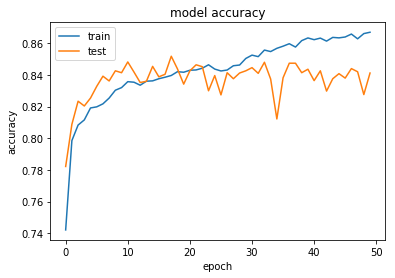

In [75]:
# here we are plotting epochs vs. accuracy 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

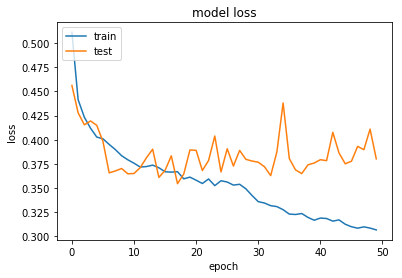

In [76]:
# here we are plotting epochs vs. loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
model.evaluate(X_test_w2v, Y_test, batch_size=16, verbose=2)

[0.36505921387910845, 0.8476]